In [11]:


# TODO: clean imports
import numpy as np
import torch
import gpytorch
from easygpr import GPRModel
import matplotlib.pyplot as plt
import easygpr.utils as utils

from easygpr.utils.settings import set_gpytorch_settings

set_gpytorch_settings()

# 
# plt.style.use('classic')
# plt.rcParams['text.usetex'] = True
# 
# import matplotlib.pylab as pylab
# params = {'legend.fontsize': 'x-large',
#           #'figure.figsize': (15, 5),
#          'axes.labelsize': 'large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'large',
#          'ytick.labelsize':'x-large',
#           'font.size': 16,
#           'text.usetex': True}
# pylab.rcParams.update(params)



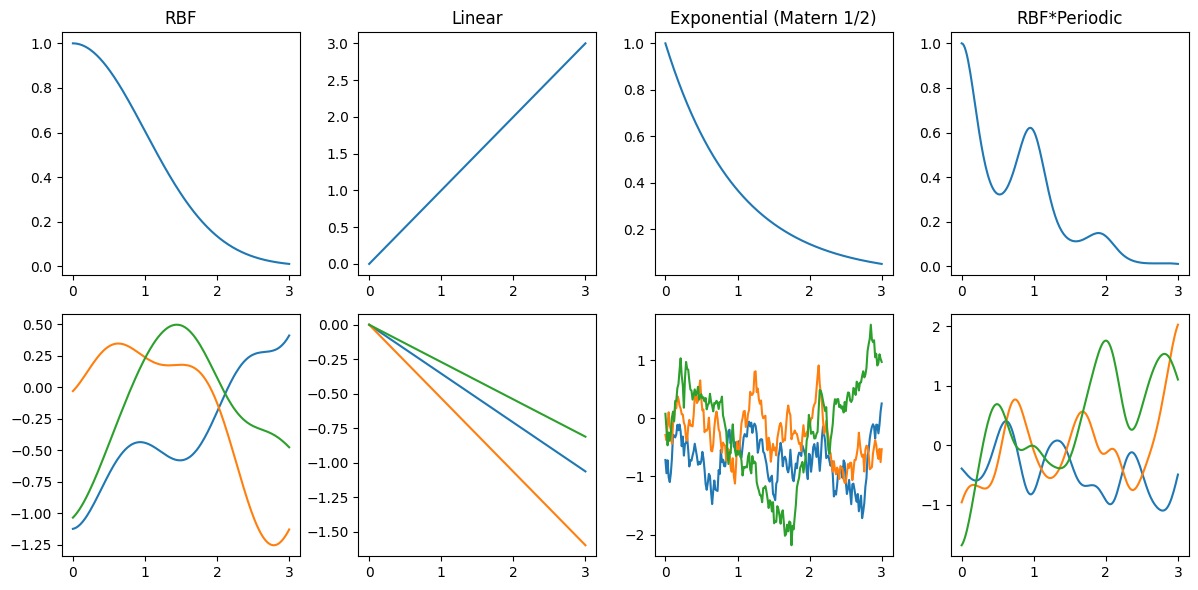

In [12]:
seed = 45678

torch.manual_seed(seed)
np.random.seed(seed)

# Define kernel functions k1 through k5, using EasyGPR and GPyTorch

# k1: RBF, lengthscale = 1
k1 = gpytorch.kernels.RBFKernel()
k1.lengthscale = 1.0

# k2: Linear (sigma^2 = 1)
k2 = gpytorch.kernels.LinearKernel()
k2.variance = 1.0

# k3: Periodic (show multiple periods attained per plot)
k3 = gpytorch.kernels.PeriodicKernel()
k3.period_length = 1
k3.lengthscale = 2.0

# k4: Exponential (Matern 1/2), lengthscale = 1
k4 = gpytorch.kernels.MaternKernel(nu=0.5)
k4.lengthscale = 1.0

# k5: k1*k2
k5 = k1 * k3

# List of kernels and their titles
kernels_list = [k1, k2, k4, k5]
titles = ['RBF', 'Linear', 'Exponential (Matern 1/2)', 'RBF*Periodic']

# Initialize a figure for the subplot panel
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Range for x-axis (0 to 3 initially, can be adjusted to 0 to 5 if necessary)
x_range = torch.linspace(0, 3, 200)

# Loop through each kernel to create plots
for i, (kernel, title) in enumerate(zip(kernels_list, titles)):
    
    # First row: Plot kernel functions
    if kernel.has_lengthscale or title == "RBF*Periodic":
        K = kernel(x_range, torch.tensor([0.0]))
        axes[0, i].plot(utils.to_numpy(x_range), utils.to_numpy(K))
    else:
        K = kernel(x_range, torch.tensor([1.0]))
        axes[0, i].plot(utils.to_numpy(x_range), utils.to_numpy(K))
    
    # Set title for the first row
    axes[0, i].set_title(title)
    
    # TODO: Create a GPRModel instance and use the simulate method to generate 3 sample paths
    for j in range(3):
        if i == 0:
            kernel = "rbf"
        elif i == 1:
            kernel = 'linear'
        elif i == 2:  # Adjusted to match the new kernel list
            kernel = "exp"
        elif i == 3:  # Adjusted to match the new kernel list
            kernel = gpytorch.kernels.RBFKernel() * gpytorch.kernels.PeriodicKernel(period_length=2)
            kernel.kernels[1].period_length = 2
        sim_model = GPRModel(kernel = kernel)
        y_sim = sim_model.simulate(utils.to_numpy(x_range), method='posterior', return_type = "numpy")
        axes[1,i].plot(utils.to_numpy(x_range), y_sim)

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig('kernel_comparison.png', dpi=600, bbox_inches='tight')  # Adjust the filename as needed
# Display the plot
plt.show()


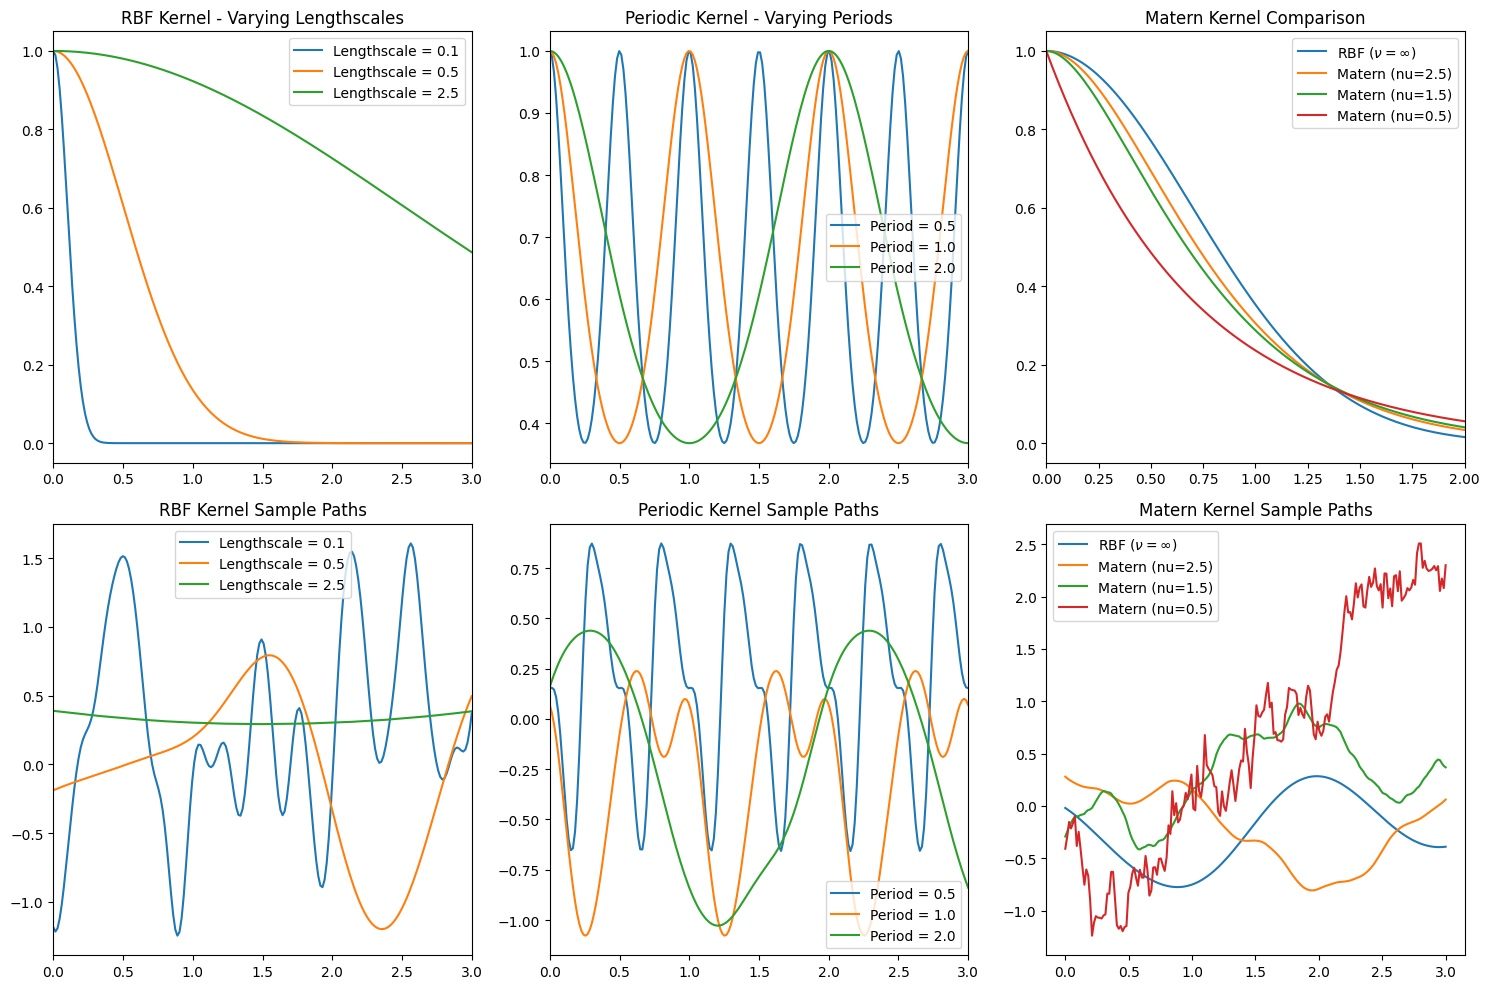

In [13]:
seed = 4569876

torch.manual_seed(seed)
np.random.seed(seed)


import torch
import gpytorch
import matplotlib.pyplot as plt
from easygpr import GPRModel


# Initialize a figure for the subplot panel
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Range for x-axis (0 to 3)
x_range = torch.linspace(0, 3, 200)

# 1,1: RBF kernel, plot of x vs k(x, 0) over x in [0, 3] with different lengthscales
lengthscales = [0.10, 0.5, 2.5]
axes[0, 0].set_title('RBF Kernel - Varying Lengthscales')
for lengthscale in lengthscales:
    kernel = gpytorch.kernels.RBFKernel()
    kernel.lengthscale = lengthscale
    K = kernel(x_range, torch.tensor([0.0]))
    axes[0, 0].plot(utils.to_numpy(x_range), utils.to_numpy(K), label=f'Lengthscale = {lengthscale}')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 3)

# 1,2: Sample paths for RBF kernel with different lengthscales
axes[1, 0].set_title('RBF Kernel Sample Paths')
for lengthscale in lengthscales:
    kernel = gpytorch.kernels.RBFKernel()
    kernel.lengthscale = lengthscale    
    sim_model = GPRModel(kernel=kernel).cuda()
    x_range_cuda = x_range.cuda()
    y_sim = sim_model.simulate(x_range_cuda.cpu().numpy(), method='posterior', return_type="numpy")
    axes[1, 0].plot(utils.to_numpy(x_range), y_sim, label=f'Lengthscale = {lengthscale}')
axes[1, 0].legend()
axes[1, 0].set_xlim(0, 3)

# Adding Periodic Kernel column
period_lengths = [0.5, 1.0, 2.0]
axes[0, 1].set_title('Periodic Kernel - Varying Periods')
for period_length in period_lengths:
    kernel = gpytorch.kernels.PeriodicKernel()
    kernel.lengthscale = 2.0
    kernel.period_length = period_length
    K = kernel(x_range, torch.tensor([0.0]))
    axes[0, 1].plot(utils.to_numpy(x_range), utils.to_numpy(K), label=f'Period = {period_length}')
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 3)

# Sample paths for Periodic kernel with different period lengths
axes[1, 1].set_title('Periodic Kernel Sample Paths')
for period_length in period_lengths:
    kernel = gpytorch.kernels.PeriodicKernel()
    kernel.lengthscale = 2.0
    kernel.period_length = period_length
    sim_model = GPRModel(kernel=kernel).cuda()
    x_range_cuda = x_range.cuda()
    y_sim = sim_model.simulate(x_range_cuda.cpu().numpy(), method='posterior', return_type="numpy")
    axes[1, 1].plot(utils.to_numpy(x_range), y_sim, label=f'Period = {period_length}')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 3)

# 1,3: Plot of x vs k(x, 0) over x in [0, 2] with different kernels (RBF and Matern)
kernels = [gpytorch.kernels.RBFKernel(), gpytorch.kernels.MaternKernel(nu=2.5), gpytorch.kernels.MaternKernel(nu=1.5), gpytorch.kernels.MaternKernel(nu=0.5)]
axes[0, 2].set_title('Matern Kernel Comparison')
for i, kernel in enumerate(kernels):
    K = kernel(x_range, torch.tensor([0.0]))
    label = f'RBF ($\\nu = \infty$)' if i == 0 else f'Matern (nu={kernel.nu})'
    axes[0, 2].plot(utils.to_numpy(x_range), utils.to_numpy(K), label=label)
axes[0, 2].legend()
axes[0, 2].set_xlim(0, 2)

# 1,4: Same as 1,3, but with one sample path per kernel and adjusted legend
axes[1, 2].set_title('Matern Kernel Sample Paths')
for i, kernel in enumerate(kernels):
    sim_model = GPRModel(kernel=kernel).cuda()
    x_range_cuda = x_range.cuda()
    y_sim = sim_model.simulate(x_range_cuda.cpu().numpy(), method='posterior', return_type="numpy")
    label = f'RBF ($\\nu = \infty$)' if i == 0 else f'Matern (nu={kernel.nu})'
    axes[1, 2].plot(utils.to_numpy(x_range), y_sim, label=label)
axes[1, 2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig('hyperparameter_comparison.png', dpi=600, bbox_inches='tight')
# Display the plot
plt.show()


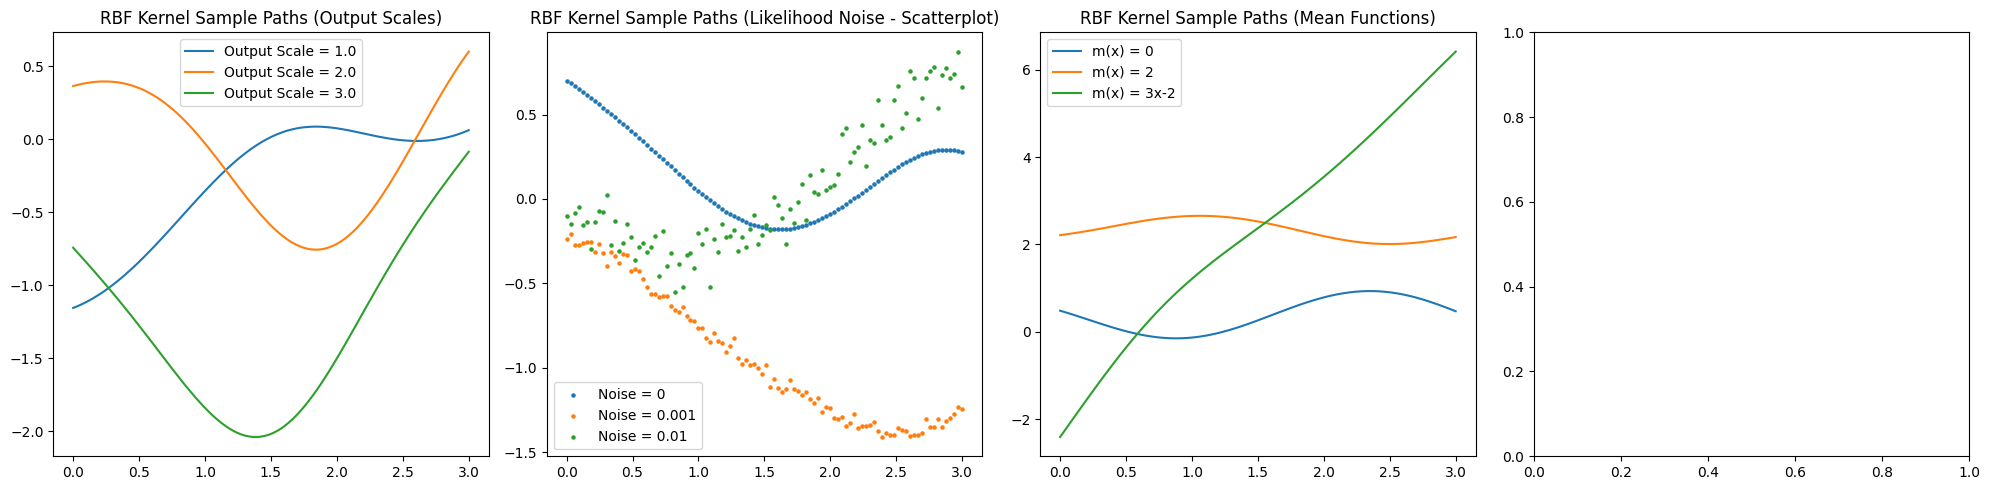

In [14]:
import torch
import gpytorch
import matplotlib.pyplot as plt

# Initialize a figure for the subplot panel
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Range for x-axis (0 to 3)
x_range = torch.linspace(0, 3, 100)



# 1,1: Sample paths for RBF kernel with different output scales
axes[0].set_title('RBF Kernel Sample Paths (Output Scales)')
output_scales = [1.0, 2.0, 3.0]
for output_scale in output_scales:
    kernel = gpytorch.kernels.RBFKernel()
    kernel.lengthscale = 1.0
    kernel.outputscale = output_scale
    sim_model = GPRModel(kernel=kernel).cuda()  # Move the GPRModel to CUDA
    x_range_cuda = x_range.cuda()  # Move x_range to CUDA
    y_sim = sim_model.simulate(x_range_cuda.cpu().numpy(), method='posterior', return_type="numpy")
    axes[0].plot(utils.to_numpy(x_range), y_sim, label=f'Output Scale = {output_scale}')
axes[0].legend()

# 1,2: Sample paths for RBF kernel with different likelihood noise levels (scatterplot)
axes[1].set_title('RBF Kernel Sample Paths (Likelihood Noise - Scatterplot)')
likelihood_noises = [1e-4, 0.001, 0.01]
for noise in likelihood_noises:
    kernel = gpytorch.kernels.RBFKernel()
    kernel.lengthscale = 1.0
    kernel.outputscale = 1.0
    sim_model = GPRModel(kernel=kernel).cuda()  # Move the GPRModel to CUDA
    sim_model.likelihood.noise = noise  # Set likelihood noise
    x_range_cuda = x_range.cuda()  # Move x_range to CUDA
    if noise == 1e-4:
        y_sim = sim_model.simulate(x_range_cuda.cpu().numpy(), method='posterior', return_type="numpy", type="f")
    else:
        y_sim = sim_model.simulate(x_range_cuda.cpu().numpy(), method='posterior', return_type="numpy", type="y")
    if noise == 1e-4:
        noise = 0
    axes[1].scatter(utils.to_numpy(x_range), y_sim, label=f'Noise = {noise}', s=5)  # Scatterplot
axes[1].legend()


# 1,3: Sample paths for RBF kernel with different mean functions
axes[2].set_title('RBF Kernel Sample Paths (Mean Functions)')
mean_functions = [0.0, 2.0, 3*x_range.cpu().numpy()-2]
labels = ["0", "2", "3x-2"]
for i, mean_func in enumerate(mean_functions):
    label = labels[i]
    kernel = gpytorch.kernels.RBFKernel()
    kernel.lengthscale = 1.0
    kernel.outputscale = 1.0
    sim_model = GPRModel(kernel=kernel).cuda()  # Move the GPRModel to CUDA
    x_range_cuda = x_range.cuda()  # Move x_range to CUDA
    y_sim = sim_model.simulate(x_range_cuda.cpu().numpy(), method='posterior', return_type="numpy", type="f")
    axes[2].plot(utils.to_numpy(x_range), y_sim + mean_func, label=f'm(x) = {label}')
axes[2].legend()


# 1,4 will be added once you provide further instructions.

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig('output_scale_misc.png', dpi=600, bbox_inches='tight')  # Adjust the filename as needed
# Display the plot
plt.show()


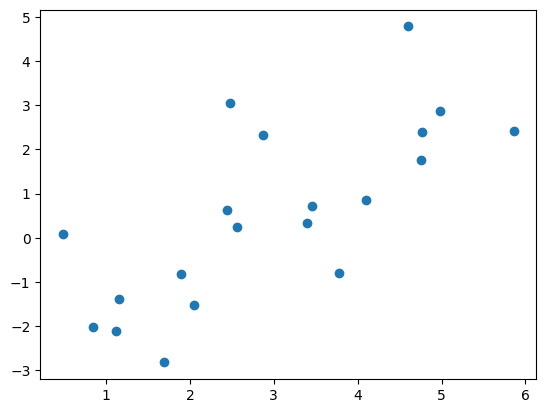

In [15]:

# Unused synthetic example
seed = 4787510

torch.manual_seed(seed)
np.random.seed(seed)

# Define the underlying function
def f(x):
    return x + np.sin(x*3) - 3

# Generate synthetic training data with noise
x_train = np.random.uniform(0, 1, 20) + np.linspace(0,5,20)
y_train = f(x_train) + np.random.normal(0, 1, x_train.shape)

plt.scatter(x_train,y_train)


In [16]:
m1 = GPRModel(train_x = x_train, train_y = y_train, kernel = "Mat52")
m1.covar_module.base_kernel.lengthscale = 0.05
m1.covar_module.base_kernel.raw_lengthscale.requires_grad = False
m1.fit_model()

m2 = GPRModel(train_x = x_train, train_y = y_train, kernel = "Mat52")
m2.covar_module.base_kernel.lengthscale = 2
m2.covar_module.base_kernel.raw_lengthscale.requires_grad = False
m2.covar_module.outputscale = 10
m2.covar_module.raw_outputscale.requires_grad = False
m2.fit_model()

m3 = GPRModel(train_x = x_train, train_y = y_train, kernel = "Mat52")
m3.fit_model()

print(m1.covar_module.base_kernel.lengthscale)
print(m2.covar_module.base_kernel.lengthscale)
print(m3.covar_module.base_kernel.lengthscale)

print(m1.covar_module.outputscale)
print(m2.covar_module.outputscale)
print(m3.covar_module.outputscale)

print(m1.likelihood.noise)
print(m2.likelihood.noise)
print(m3.likelihood.noise)



Fitting complete.
--- 
--- final mll: -1.9413
--- num_params: 4
--- BIC: 15.8654
Fitting complete.
--- 
--- final mll: -2.0134
--- num_params: 4
--- BIC: 16.0097
Fitting complete.
--- 
--- final mll: -1.8693
--- num_params: 4
--- BIC: 15.7214
tensor([[0.0500]])
tensor([[2.]])
tensor([[0.1106]], grad_fn=<SoftplusBackward0>)
tensor(1.8942, grad_fn=<SoftplusBackward0>)
tensor(10.)
tensor(2.0498, grad_fn=<SoftplusBackward0>)
tensor([1.4848], grad_fn=<AddBackward0>)
tensor([1.9704], grad_fn=<AddBackward0>)
tensor([1.6254], grad_fn=<AddBackward0>)


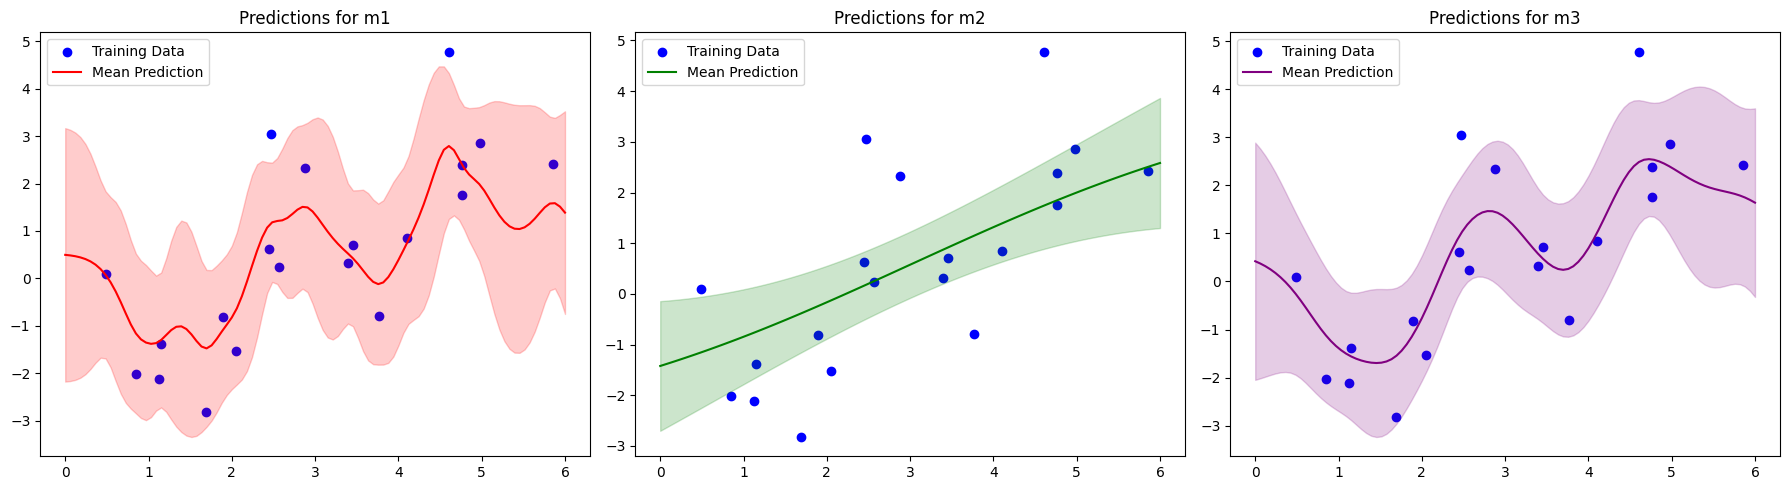

In [17]:
# Create a range of test inputs for predictions
x_test = torch.linspace(0, 6, 100)

# Make predictions for m1
predictions_m1 = m1.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")

# Make predictions for m2
predictions_m2 = m2.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")

# Make predictions for m3
predictions_m3 = m3.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")  # Assuming you have a model named m3

# Create a 1x3 subplot layout for the predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Adjust the figsize to accommodate the third panel

# Plot predictions for m1
axes[0].set_title('Predictions for m1')
axes[0].scatter(x_train, y_train, label='Training Data', color='blue')
axes[0].plot(utils.to_numpy(x_test), predictions_m1.mean, label='Mean Prediction', color='red')
axes[0].fill_between(utils.to_numpy(x_test), predictions_m1.mean - 1.96*np.sqrt(predictions_m1.variance), predictions_m1.mean + 1.96*np.sqrt(predictions_m1.variance), alpha=0.2, color='red')
axes[0].legend()

# Plot predictions for m2
axes[1].set_title('Predictions for m2')
axes[1].scatter(x_train, y_train, label='Training Data', color='blue')
axes[1].plot(utils.to_numpy(x_test), predictions_m2.mean, label='Mean Prediction', color='green')
axes[1].fill_between(utils.to_numpy(x_test), predictions_m2.mean - 1.96*np.sqrt(predictions_m2.variance), predictions_m2.mean + 1.96*np.sqrt(predictions_m2.variance), alpha=0.2, color='green')
axes[1].legend()

# Plot predictions for m3
axes[2].set_title('Predictions for m3')  # Set the title for the third panel
axes[2].scatter(x_train, y_train, label='Training Data', color='blue')
axes[2].plot(utils.to_numpy(x_test), predictions_m3.mean, label='Mean Prediction', color='purple')  # Adjust color and label for m3
axes[2].fill_between(utils.to_numpy(x_test), predictions_m3.mean - 1.96*np.sqrt(predictions_m3.variance), predictions_m3.mean + 1.96*np.sqrt(predictions_m3.variance), alpha=0.2, color='purple')  # Adjust color for m3
axes[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


In [18]:
m1.fit_model()

Fitting complete.
--- 
--- final mll: -1.9372
--- num_params: 4
--- BIC: 15.8574


GPRModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

Fitting complete.
--- 
--- final mll: -1.6312
--- num_params: 4
--- BIC: 15.2449
Fitting complete.
--- 
--- final mll: -1.5050
--- num_params: 4
--- BIC: 25.0958


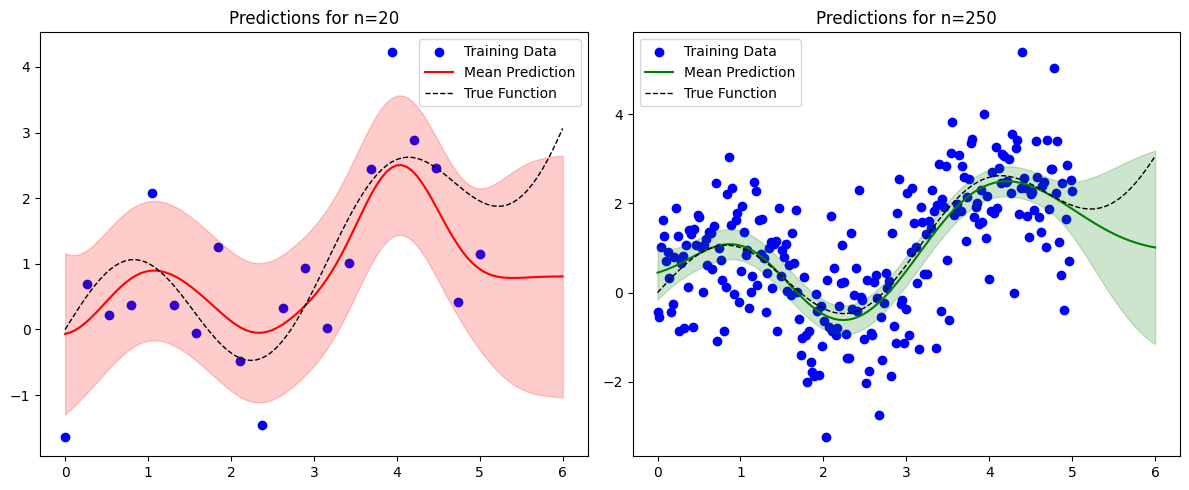

In [19]:
# Code relevant for the synthetic example

seed = 235789

torch.manual_seed(seed)
np.random.seed(seed)

# Define the underlying function
def f(x):
    return 0.1 * x**2 + np.sin(x * 2)

# Generate synthetic training data with noise for n=20
x_train_20 = np.linspace(0, 5, 20)
y_train_20 = f(x_train_20) + np.random.normal(0, 1, x_train_20.shape)

# Generate synthetic training data with noise for n=250
x_train_250 = np.linspace(0, 5, 250)
y_train_250 = f(x_train_250) + np.random.normal(0, 1, x_train_250.shape)

# Create a range of test inputs
x_test = torch.linspace(0, 6, 100)

# Create GPR models for n=20 and n=250
m_20 = GPRModel(train_x=x_train_20, train_y=y_train_20, kernel="rbf")

m_20.fit_model()

m_250 = GPRModel(train_x=x_train_250, train_y=y_train_250, kernel="rbf")

m_250.fit_model()

# Make predictions for n=20 and n=250
predictions_20 = m_20.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")
predictions_250 = m_250.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")

# Create a 1x2 subplot layout for the predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x_test = utils.to_numpy(x_test)

# Plot predictions for n=20
axes[0].set_title('Predictions for n=20')
axes[0].scatter(x_train_20, y_train_20, label='Training Data', color='blue')
axes[0].plot(x_test, predictions_20.mean, label='Mean Prediction', color='red')
axes[0].fill_between(x_test, predictions_20.mean - 1.96*np.sqrt(predictions_20.variance), predictions_20.mean + 1.96*np.sqrt(predictions_20.variance), alpha=0.2, color='red')
axes[0].plot(x_test, f(x_test), '--', label='True Function', color='black', linewidth=1)
axes[0].legend()

# Plot predictions for n=250
axes[1].set_title('Predictions for n=250')
axes[1].scatter(x_train_250, y_train_250, label='Training Data', color='blue')
axes[1].plot(x_test, predictions_250.mean, label='Mean Prediction', color='green')
axes[1].fill_between(x_test, predictions_250.mean - 1.96*np.sqrt(predictions_250.variance), predictions_250.mean + 1.96*np.sqrt(predictions_250.variance), alpha=0.2, color='green')
axes[1].plot(x_test, f(x_test), '--', label='True Function', color='black', linewidth=1)
axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as synthetic1_GP-n20-vs-250.png
plt.savefig('synthetic1_GP-n20-vs-250.png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()
